In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import numpy as np

from load_wastewater_data import load_systems_data
from plotting_tools import *

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_0_0001", "constant_decay_0_025"

simno = 1

In [3]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"

plot_path = f"../plots/wastewater_model/correlation"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

In [4]:
df_wastewater = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")
df_wastewater["hours"] = df_wastewater["minutes"]/60
df_wastewater = df_wastewater[[int(x)==x for x in df_wastewater.hours]] # only subselect full hours

df_wastewater_sub = df_wastewater.loc[df_wastewater['memilio_id'] == simno]
df_wastewater_sub = df_wastewater_sub.loc[df_wastewater_sub['sampling_point'] == "16"]
df_wastewater_sub.head()

,minutes,COVID_copies/l,PMMoV_copies/l,sampling_point,memilio_id,time_in_days,hours
9807262,10020,134.16467,83.33334,16,1,6.958333,167.0
9807284,10080,134.17459,83.33334,16,1,7.000000,168.0
9807306,10140,128.49924,83.33334,16,1,7.041667,169.0
9807328,1020,111.55022,83.33334,16,1,0.708333,17.0
9807329,10200,126.13262,83.33334,16,1,7.083333,170.0


In [5]:
def viral_load(t, tau_E, tau_I_ns, tau_infected):
    peak_value = 8.1
    incline = peak_value / (tau_E + tau_I_ns) # peak value divided by sum of incubation and non-symptomatic infection period
    if round(tau_E + tau_I_ns, 10) == round(tau_infected, 10):
        # non-symptomatic infection
        tau_peak = 0.5*tau_infected
        peak_value = incline * tau_peak
    else:
        tau_peak = tau_E + tau_I_ns
    decline = -peak_value / (tau_infected - tau_peak)
    if t < 0:
        return 0
    elif t <= tau_peak:
        return incline * t
    elif t <= tau_infected:
        return peak_value + decline*(t - tau_peak)
    else:
        return 0


def shedding(t, tau_E, tau_I_ns, tau_infected):
    c1 = -7
    c2 = 1
    shedding = 1/(1+np.exp(-(c1+c2*viral_load(t, tau_E, tau_I_ns, tau_infected))))
    return shedding


def infectiousness(t_since_transmission, tau_E, tau_I_ns, tau_infected):
    kappa = 10**(7.1) 

    if t_since_transmission < 0:
        return 0

    t_shift = tau_E*0.6

    t_s_end = tau_infected

    if t_shift <= t_since_transmission and t_since_transmission <= t_s_end:
        infectiousness = kappa * shedding((t_since_transmission - t_shift), tau_E, tau_I_ns, tau_infected)
    else:
        infectiousness = 0

    return infectiousness

def load_infection_path_information(simulation_id, experiment_series):
    """
    This function loads the infection path information from the MEmilio output and returns a tidied version of it.

    Parameters
    ----------
    simulation_id : int
        identifier of memilio simulation
    experiment_series : str
        name of the experiment series in which the simulation was run

    Returns
    -------
    pd.DataFrame
        with columns agent_id, t_exposed (time span of exposure), t_infected (time span of infection), hospitalized (whether or not the agent was hospitalized)
    """
    # read in infection paths
    infection_paths = pd.read_csv(f"../../simulation_output/infection_model/{experiment_series}/{simulation_id}_infection_paths.txt", header=0, index_col=None, sep=" ").reset_index()
    new_cols = infection_paths.columns[1:].to_list()
    new_cols.append("bla")
    infection_paths.columns = new_cols
    infection_paths = infection_paths.drop(columns="bla")

    # infection duration
    infection_paths["t_infected"] = infection_paths["E"] + infection_paths["I_ns"] + infection_paths["I_sy"] + infection_paths["I_sev"] + infection_paths["I_cri"]
    infection_paths["hospitalized"] = infection_paths["I_sev"] + infection_paths["I_cri"] > 0

    # For the shedding curve, we only need the agent id, duration of infection, the duration of exposure, and whether the agent was hospitalized
    infection_paths = infection_paths[["Agent_id", "E", "I_ns", "t_infected", "hospitalized"]]
    infection_paths.columns = ["agent_id", "t_exposed", "t_nonsymptomatic", "t_infected", "hospitalized"]
    
    # change time scale to days
    infection_paths[["t_exposed", "t_nonsymptomatic", "t_infected"]] = infection_paths[["t_exposed", "t_nonsymptomatic", "t_infected"]] / 24

    return infection_paths

In [6]:
df_agent_trajectory = pd.read_csv(f"{infection_model_output_path}/agent_trajectories/agent_trajectories_{simno}.csv", index_col=0)
df_agent_trajectory["systems_location"] = df_agent_trajectory["systems_location"].astype(str).apply(lambda x: x.zfill(5))
df_agent_trajectory["infected"] = df_agent_trajectory["time_since_transmission"] > 0
infection_path = load_infection_path_information(simno, experiment_series)
df_agent_trajectory = df_agent_trajectory.merge(infection_path, on="agent_id")

In [8]:
df_agent_trajectory["t_exposed"] = df_agent_trajectory["t_exposed"].astype(float)
df_agent_trajectory["t_infected"] = df_agent_trajectory["t_infected"].astype(float)

rel_rows = (df_agent_trajectory["time_since_transmission"]>0) & (df_agent_trajectory["t_exposed"]==0)
new_t_E = df_agent_trajectory.loc[rel_rows,:].groupby("agent_id")["time_since_transmission"].min().reset_index().rename(columns={"time_since_transmission": "t_exposed_new"})
new_t_E["t_exposed_new"] = new_t_E["t_exposed_new"]

df_agent_trajectory = df_agent_trajectory.merge(new_t_E, on="agent_id", how="left")

df_agent_trajectory.loc[rel_rows, "t_exposed"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"]
df_agent_trajectory.loc[rel_rows, "t_infected"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"] + df_agent_trajectory.loc[rel_rows, "t_infected"]

df_agent_trajectory.drop(columns="t_exposed_new", inplace=True)

df_agent_trajectory["shedding"] = df_agent_trajectory.apply(lambda row: infectiousness(row["time_since_transmission"], row["t_exposed"], row["t_nonsymptomatic"], row["t_infected"]), axis=1)

In [9]:
# Total infectiousness across all infected agents
total_infectiousness = df_agent_trajectory.groupby("time_in_days").sum()["shedding"].reset_index()
df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory['infected'] == True]

total_infectiousness.tail()

#inf_times = df_agent_trajectory.groupby("agent_id").min()["time_in_days"].reset_index()
#inf_times = inf_times.loc[inf_times['time_in_days'] > 0.05, :]
#rec_times = df_agent_trajectory.groupby("agent_id").max()["time_in_days"].reset_index()
#rec_times = rec_times.loc[rec_times['time_in_days'] < 14, :]

,time_in_days,shedding
332,13.833333,9.856360e+06
333,13.875000,9.629135e+06
334,13.916667,9.404187e+06
335,13.958333,9.181520e+06
336,14.000000,8.961144e+06


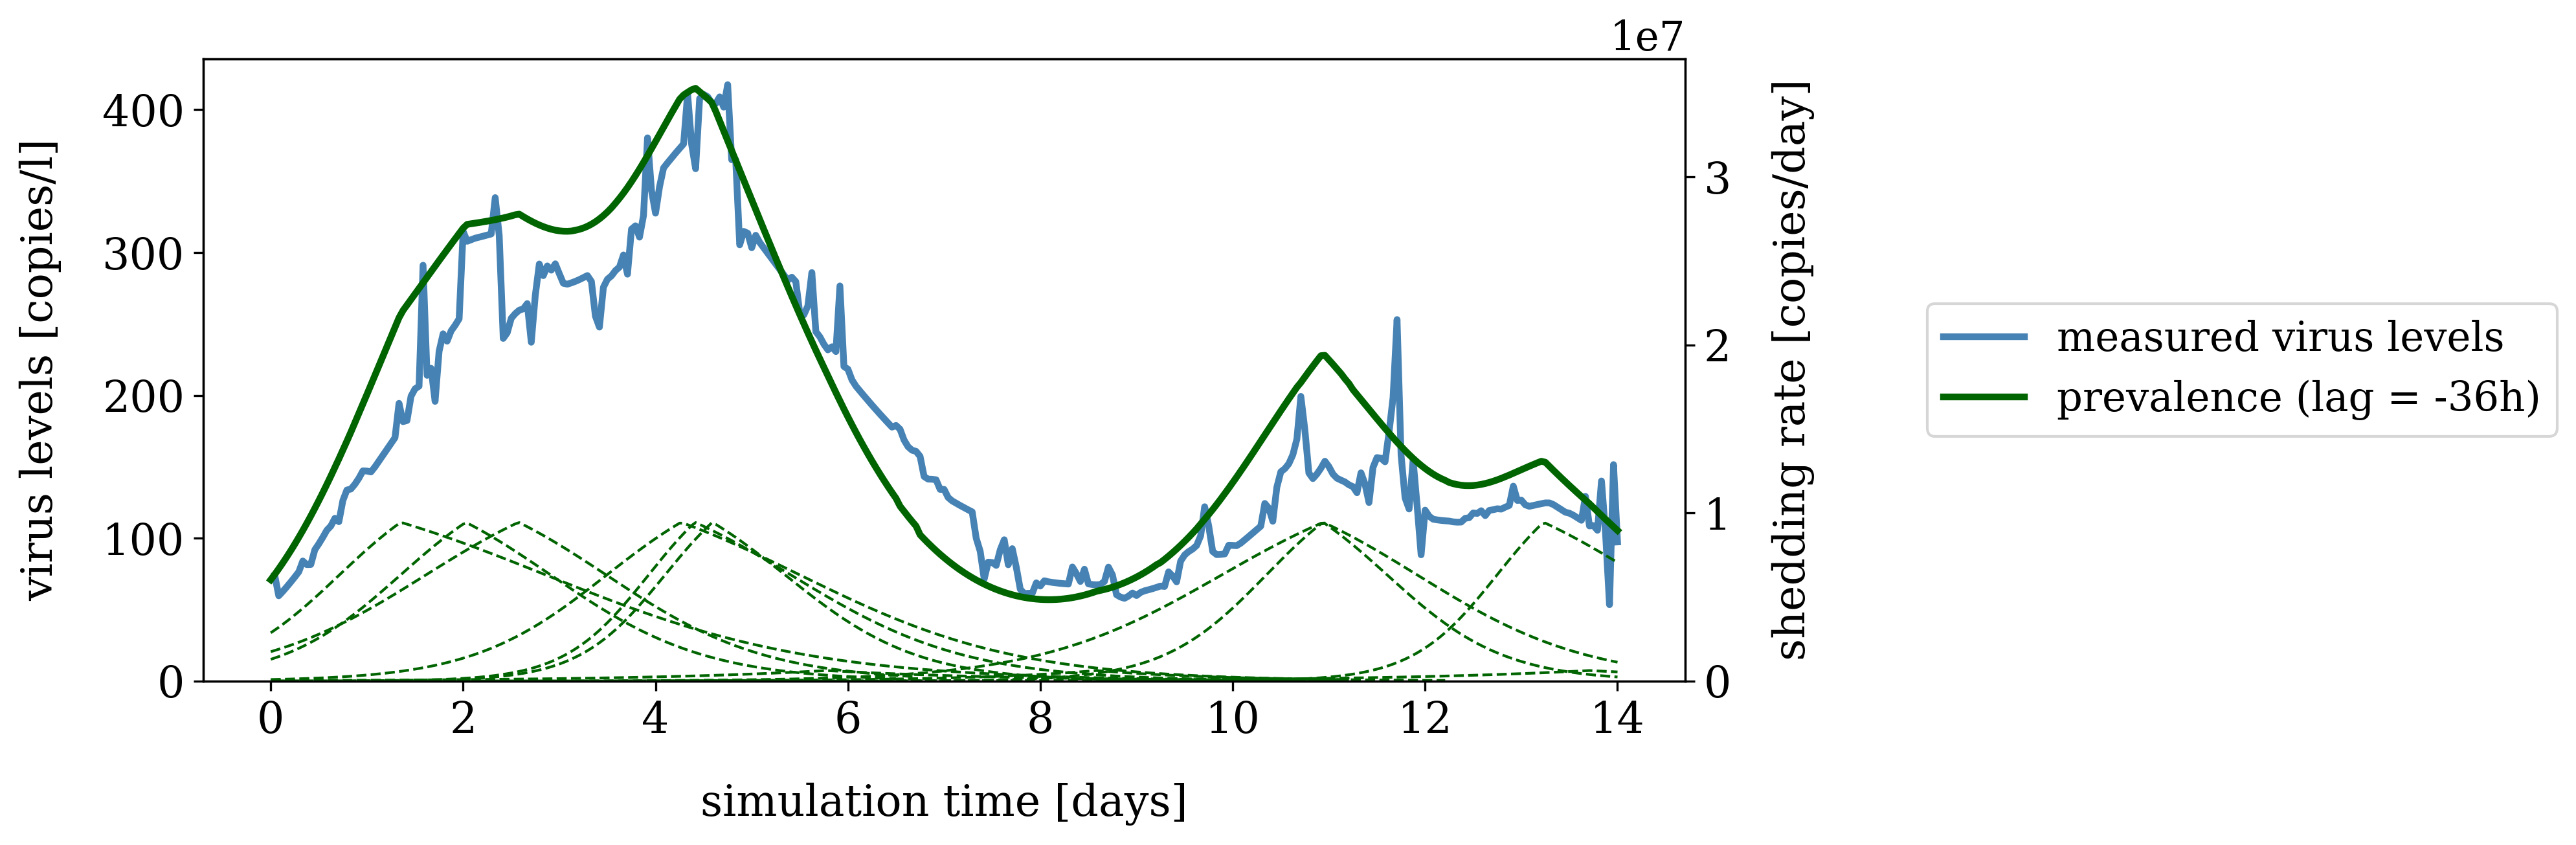

In [10]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (11.5,3.6), dpi=300)

# Right plot: summed infectiousness vs. wastewater viral loads
# Plot copies/l on primary y-axis
sns.lineplot(x=df_wastewater_sub["time_in_days"], y=df_wastewater_sub["COVID_copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2.5)
ax1.set_ylabel('virus levels [copies/l]')
ax1.tick_params(axis='y')
ax1.set_ylim(ymin=0)

# Create secondary y-axis for summed infectiousness
ax2 = ax1.twinx()
sns.lineplot(x=total_infectiousness["time_in_days"], y=total_infectiousness["shedding"], ax=ax2, label=f"prevalence (lag = -36h)", color='darkgreen', linewidth=2.5)

for agent in df_agent_trajectory.loc[:,"agent_id"].unique():
    temp = df_agent_trajectory.loc[df_agent_trajectory.agent_id==agent,:]
    sns.lineplot(x=temp["time_in_days"], y=temp["shedding"], ax=ax2, color='darkgreen', linewidth=1, linestyle='--')

# Customize secondary y-axis
ax2.set_ylabel('shedding rate [copies/day]')
ax2.tick_params(axis='y')
ax2.set_ylim(ymin=0)
 
# Customize x-axis
ax1.set_xlabel('simulation time [days]')

# for agent in inf_times.loc[:,"agent_id"].unique():
#     val = inf_times.loc[inf_times.agent_id==agent,'time_in_days'].iloc[0]
#     plt.axvline(x=val) 

#plt.axvline(x=5.33, color = "#FFC107", )

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

ax1.set_yticks([0, 100, 200, 300, 400])
#ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8]) 

# # Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_ww_prev_infectiousness.png"), dpi=300)

In [13]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

def get_crosscorr_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["shedding"], lag) for lag in lags_in_hours]

In [14]:
# note: takes about 3h to run
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

max_lag = 45

results = []
nas = []
for sampling_location in df_wastewater.loc[:,"sampling_point"].astype(int).sort_values().unique():

    loc_corr = []
    for sim in df_wastewater['memilio_id'].unique():
        curr_sim_ww = df_wastewater.loc[df_wastewater['memilio_id'] == sim]

        df_agent_trajectory = pd.read_csv(f"{infection_model_output_path}/agent_trajectories/agent_trajectories_{sim}.csv", index_col=0)
        infection_path = load_infection_path_information(sim, experiment_series)
        df_agent_trajectory = df_agent_trajectory.merge(infection_path, on="agent_id")
        df_agent_trajectory["t_exposed"] = df_agent_trajectory["t_exposed"].astype(float)
        df_agent_trajectory["t_infected"] = df_agent_trajectory["t_infected"].astype(float)
        rel_rows = (df_agent_trajectory["time_since_transmission"]>0) & (df_agent_trajectory["t_exposed"]==0)
        new_t_E = df_agent_trajectory.loc[rel_rows,:].groupby("agent_id")["time_since_transmission"].min().reset_index().rename(columns={"time_since_transmission": "t_exposed_new"})
        df_agent_trajectory = df_agent_trajectory.merge(new_t_E, on="agent_id", how="left")
        df_agent_trajectory.loc[rel_rows, "t_exposed"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"]
        df_agent_trajectory.loc[rel_rows, "t_infected"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"] + df_agent_trajectory.loc[rel_rows, "t_infected"]
        df_agent_trajectory.drop(columns="t_exposed_new", inplace=True)
        df_agent_trajectory["shedding"] = df_agent_trajectory.apply(lambda row: infectiousness(row["time_since_transmission"], row["t_exposed"], row["t_nonsymptomatic"], row["t_infected"]), axis=1)
        curr_sim_inf = df_agent_trajectory.groupby("time_in_days").sum()["shedding"].reset_index()

        curr_combined = curr_sim_ww.merge(curr_sim_inf, left_on="time_in_days", right_on="time_in_days", how="left")
        loc_corr.append(get_crosscorr_for_one_station(curr_combined, str(sampling_location), range(-max_lag, max_lag+1, 1)))
        print(sim)

    df_corr = pd.DataFrame(loc_corr)
    results.append(df_corr.mean(axis = 0))
    nas.append(250 - sum(df_corr.transpose().isna().sum() > 0))
    print(sampling_location)

df_res = pd.DataFrame(results).transpose()
df_res.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
df_res["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res = df_res.set_index("lag_in_h")

df_nas = pd.DataFrame(nas).transpose()
df_nas.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']

1
2
1
1
2
2
1
2
3
1
2
4
1
2
5
1
2
6
1
2
7
1
2
8
1
2
9
1
2
10
1
2
11
1
2
12
1
2
13
1
2
14
1
2
15
1
2
16


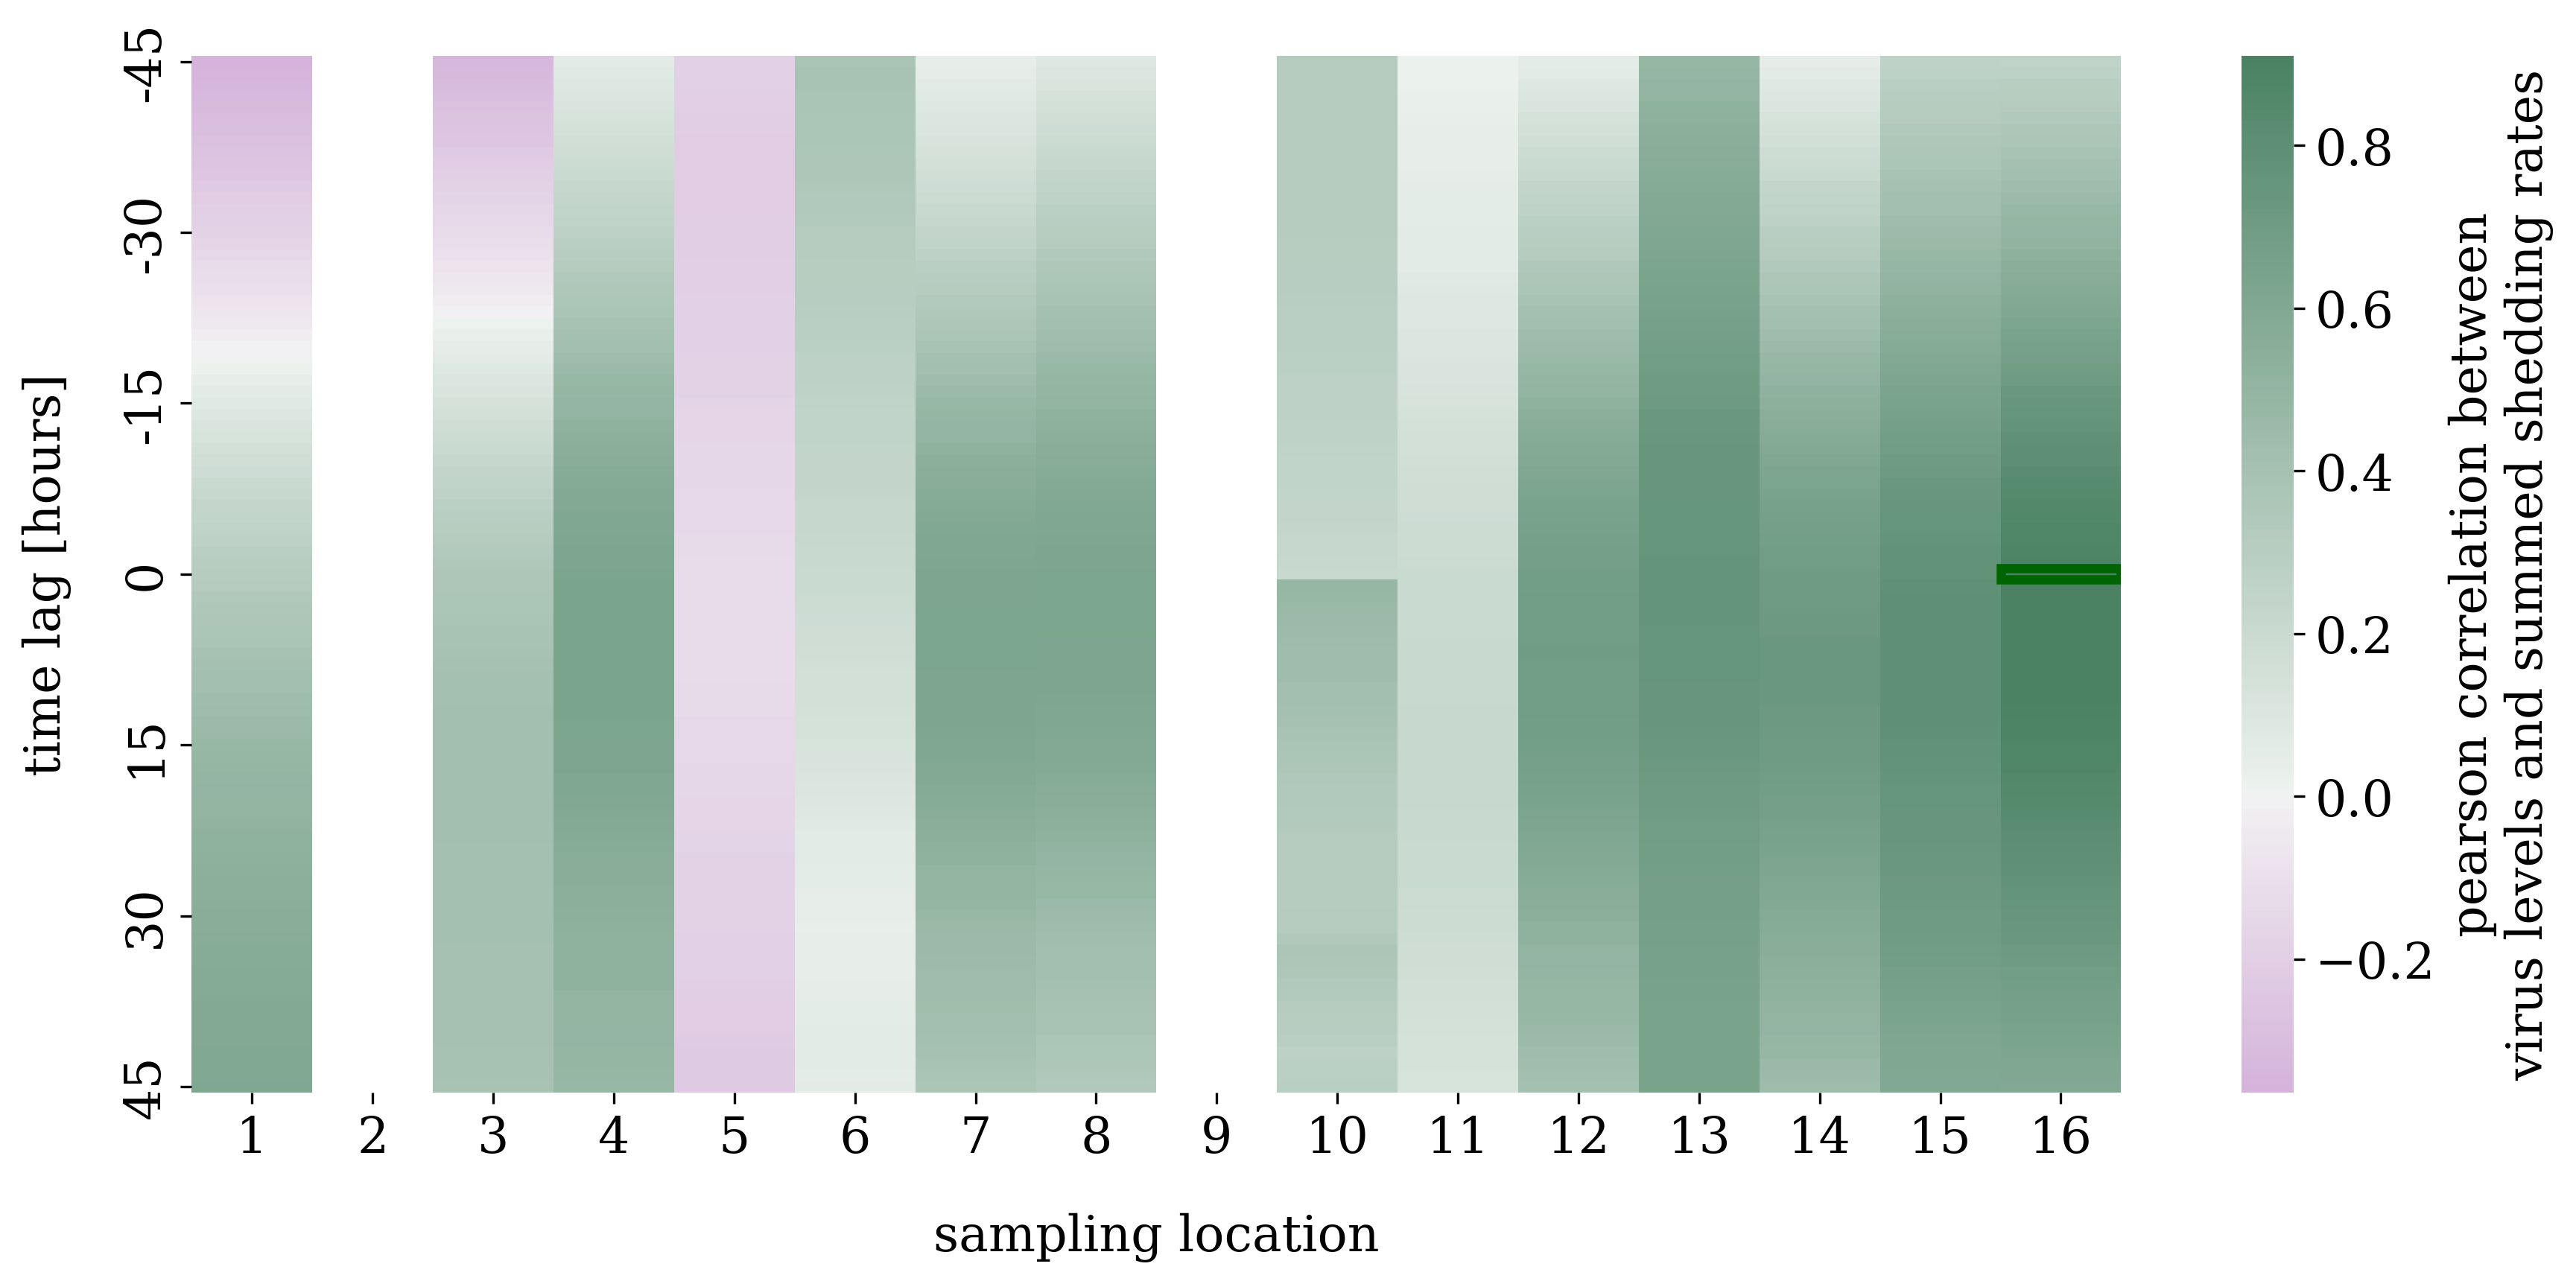

In [15]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (9,4.5), dpi=300)
lb = sns.heatmap(df_res[[str(i) for i in range(1,17)]], cmap=sns.diverging_palette(300, 145, s=60, as_cmap=True), center=0, yticklabels=15, cbar_kws={'label': 'pearson correlation between\nvirus levels and summed shedding rates'})
ax.set_xlabel("sampling location")
ax.set_ylabel("time lag [hours]")

lag = 0
ax.add_patch(Rectangle((15, df_res.index.get_loc(-lag)), 1, 1, fill=False, edgecolor="darkgreen", lw=3))

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_inf_cross_correlation.png"), dpi=300)

### Find range of viral load slopes

In [ ]:
def find_incline(tau_E, tau_I_ns):
    peak_value = 8.1
    incline = peak_value / (tau_E + tau_I_ns) 
    return incline
    
def find_decline(tau_E, tau_I_ns, tau_infected):
    peak_value = 8.1
    incline = peak_value / (tau_E + tau_I_ns)
    if round(tau_E + tau_I_ns, 10) == round(tau_infected, 10):
        tau_peak = 0.5*tau_infected
        peak_value = incline * tau_peak
    else:
        tau_peak = tau_E + tau_I_ns
    decline = -peak_value / (tau_infected - tau_peak)
    return decline

def find_incline_and_decline(sim_no):
    infection_path = load_infection_path_information(sim_no, experiment_series)
    infection_path = infection_path.loc[infection_path.t_infected > 0]
    infection_path["incline"] = infection_path.apply(lambda row: find_incline(row["t_exposed"], row["t_nonsymptomatic"]), axis=1)
    infection_path["decline"] = infection_path.apply(lambda row: find_decline(row["t_exposed"], row["t_nonsymptomatic"], row["t_infected"]), axis=1)
    return infection_path

df_slopes = [find_incline_and_decline(sim_no) for sim_no in range(1, 251)]
df_slopes = pd.concat(df_slopes)

print(df_slopes["incline"].quantile(0.025).round(1))
print(df_slopes["incline"].quantile(0.975).round(1))

print(df_slopes["decline"].quantile(0.025).round(1))
print(df_slopes["decline"].quantile(0.975).round(1))